<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Visualizing CARTs with admissions data

_Authors: Kiefer Katovich (SF)_

---

Using the admissions data from earlier in the course, build CARTs, look at how they work visually, and compare their performance to more standard, parametric models.


---

### 1. Install and load the packages required to visually show decision tree branching

You will need to first:

1. Install `graphviz` with homebrew (on OSX - not sure what linux uses). The command will be `brew install graphviz`
- Install `pydotplus` with `pip install pydotplus`
- Load the packages as shown below (you may need to restart the kernel after the installations.)

In [1]:
# REQUIREMENTS:
# pip install pydotplus
# brew install graphviz

# Use graphviz to make a chart of the regression tree decision points:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

---

### 2. Load in admissions data and other python packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
admit = pd.read_csv('./datasets/admissions.csv')

In [4]:
admit.head()

,admit,gre,gpa,prestige
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.00,1.0
3,1,640.0,3.19,4.0
4,0,520.0,2.93,4.0


In [5]:
admit.shape
# 400 rows, 4 columns

(400, 4)

In [6]:
admit.info()
# 0 nulls in 'admit', 2 nulls in 'gre', 2 nulls in 'gpa', and 1 null in 'prestige

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
admit       400 non-null int64
gre         398 non-null float64
gpa         398 non-null float64
prestige    399 non-null float64
dtypes: float64(3), int64(1)
memory usage: 12.6 KB


In [7]:
admit.isnull().sum()
# confirms conclusions from .info above. need to fix the nulls.

admit       0
gre         2
gpa         2
prestige    1
dtype: int64

In [8]:
# drop the null values and re-check for nulls to confirm
admit.dropna(inplace=True)
admit.isnull().sum()

admit       0
gre         0
gpa         0
prestige    0
dtype: int64

In [9]:
admit.shape
# 397 rows after removal of the null values

(397, 4)

---

### 3. Create regression and classification X, y data

The regression data will be:

    Xr = [admit, gre, prestige]
    yr = gpa
    
The classification data will be:

    Xc = [gre, gpa, prestige]
    yc = admit

In [10]:
# A:
# Regression data
Xr = admit[['admit', 'gre', 'prestige']]
yr = admit['gpa']

# Classification data
Xc = admit[['gre', 'gpa', 'prestige']]
yc = admit['admit']

In [11]:
print('Xr ', Xr.shape)
print('yr ', yr.shape)
print('Xc', Xc.shape)
print('yc', yc.shape)

Xr  (397, 3)
yr  (397,)
Xc (397, 3)
yc (397,)


In [12]:
# scale the data before modeling
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xrs = ss.fit_transform(Xr)
Xcs = ss.fit_transform(Xc)

---

### 4. Cross-validate regression and logistic regression on the data

Fit a linear regression for the regression problem and a logistic for the classification problem. Cross-validate the R2 and accuracy scores.

In [13]:
# A:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score

In [14]:
# Linear regression
linreg = LinearRegression()
cvs_lin = cross_val_score(linreg, Xrs, yr, cv=4)  # cross-validation
print(cvs_lin, np.mean(cvs_lin))     # show scores
R2 = linreg.fit(Xrs, yr)   # fit the models
print('R^2: ', R2)


# Logistic regression
logreg = LogisticRegression()
cvs_log = cross_val_score(logreg, Xcs, yc, cv=4)
print(cvs_log, np.mean(cvs_log))
accuracy = logreg.fit(Xcs, yc)
print('accuracy: ', accuracy)

[ 0.22470964  0.08296819  0.03204903  0.16434809] 0.12601873539
R^2:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
[ 0.71        0.73        0.6969697   0.71428571] 0.712813852814
accuracy:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [15]:
# Linear regression has R^2 0.12601873539 (bad), while Logistic regression has R^2 0.712813852814 (much better but
# still not great)

---

### 5. Building regression trees

With `DecisionTreeRegressor`:

1. Build 4 models with different parameters for `max_depth`: `max_depth=1`, `max_depth=2`, `max_depth=3`, and `max_depth=None`
2. Cross-validate the R2 scores of each of the models and compare to the linear regression earlier.

In [16]:
# A:
from sklearn.tree import DecisionTreeRegressor

In [17]:
# set 4 models
dtree1 = DecisionTreeRegressor(max_depth=1)
dtree2 = DecisionTreeRegressor(max_depth=2)
dtree3 = DecisionTreeRegressor(max_depth=3)
dtreeN = DecisionTreeRegressor(max_depth=None)

In [18]:
# fit the models
dtree1.fit(Xrs, yr)
dtree2.fit(Xrs, yr)
dtree3.fit(Xrs, yr)
dtreeN.fit(Xrs, yr)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [19]:
# cross validation
cvs_dt1 = cross_val_score(dtree1, Xrs, yr, cv=4)
print('Tree 1 ', cvs_dt1, np.mean(cvs_dt1))
cvs_dt2 = cross_val_score(dtree2, Xrs, yr, cv=4)
print('Tree 2', cvs_dt2, np.mean(cvs_dt2))
cvs_dt3 = cross_val_score(dtree3, Xrs, yr, cv=4)
print('Tree 3 ', cvs_dt3, np.mean(cvs_dt3))
cvs_dtN = cross_val_score(dtreeN, Xrs, yr, cv=4)
print('Tree N ', cvs_dtN, np.mean(cvs_dtN))

Tree 1  [ 0.16618105  0.1535036   0.03860296  0.10081223] 0.114774961104
Tree 2 [ 0.20722899  0.14179888  0.04112242  0.11836674] 0.127129257986
Tree 3  [ 0.15422529  0.123802    0.05252648  0.08070045] 0.102813557478
Tree N  [-0.14399876 -0.14516273 -0.4649248  -0.16230542] -0.229097925636


In [20]:
# The earlier linear regression had an R^2 score of 0.12601873539. Only Tree 2 is slightly better, and Tree N is a
# lot worse.

---

### 6. Visualizing the regression tree decisions

Use the template code below to create charts that show the logic/branching of your four decision tree regressions from above.

#### Interpreting a regression tree diagram

- First line is the condition used to split that node (go left if true, go right if false)
- `samples` is the number of observations in that node before splitting
- `mse` is the mean squared error calculated by comparing the actual response values in that node against the mean response value in that node
- `value` is the mean response value in that node

In [21]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

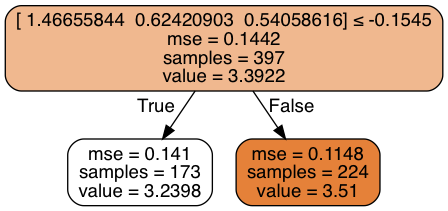

In [22]:
# Tree 1

# initialize the output file object
dot_data = StringIO() 

# my fit DecisionTreeRegressor object here is: dtree1
# for feature_names i put the columns of my Xr matrix
export_graphviz(dtree1, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=Xrs)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

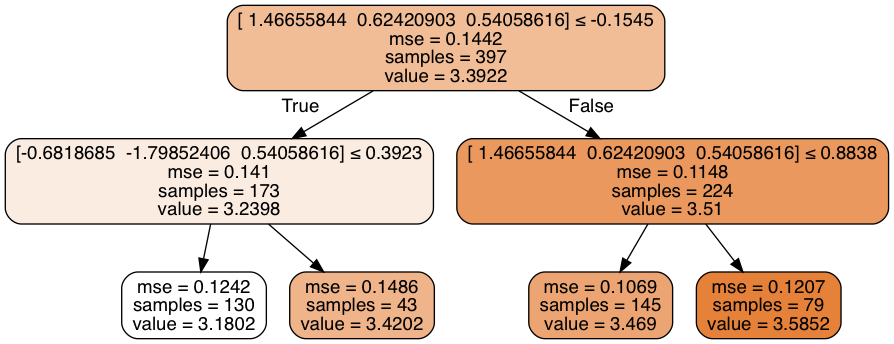

In [23]:
# Tree 2

# initialize the output file object
dot_data = StringIO() 

# my fit DecisionTreeRegressor object here is: dtree1
# for feature_names i put the columns of my Xr matrix
export_graphviz(dtree2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=Xrs)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

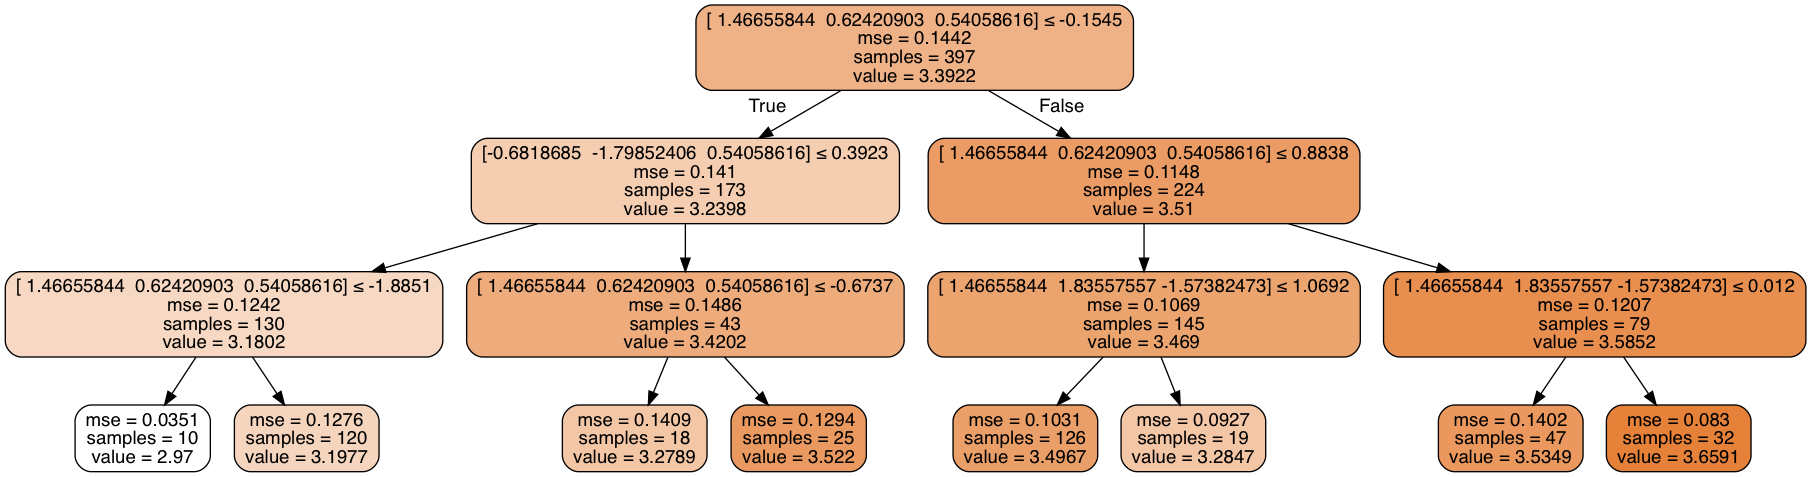

In [24]:
# Tree 3

# initialize the output file object
dot_data = StringIO() 

# my fit DecisionTreeRegressor object here is: dtree1
# for feature_names i put the columns of my Xr matrix
export_graphviz(dtree3, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=Xrs)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

In [25]:
# Tree N

# initialize the output file object
dot_data = StringIO() 

# my fit DecisionTreeRegressor object here is: dtree1
# for feature_names i put the columns of my Xr matrix
export_graphviz(dtreeN, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=Xrs)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


---

### 7. Building classification trees

With `DecisionTreeClassifier`:

1. Again build 4 models with different parameters for `max_depth`: `max_depth=1`, `max_depth=2`, `max_depth=3`, and `max_depth=None`
2. Cross-validate the accuracy scores of each of the models and compare to the logistic regression earlier.

Note that now you'll be using the classification task where we are predicting `admit`.

In [26]:
from sklearn.tree import DecisionTreeClassifier

In [27]:
# set 4 models
dtree1c = DecisionTreeClassifier(max_depth=1)
dtree2c = DecisionTreeClassifier(max_depth=2)
dtree3c = DecisionTreeClassifier(max_depth=3)
dtreeNc = DecisionTreeClassifier(max_depth=None)

In [28]:
# fit the models
dtree1c.fit(Xcs, yc)
dtree2c.fit(Xcs, yc)
dtree3c.fit(Xcs, yc)
dtreeNc.fit(Xcs, yc)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [29]:
# cross validation
cvs_dt1c = cross_val_score(dtree1c, Xcs, yc, cv=4)
print('Tree 1 ', cvs_dt1c, np.mean(cvs_dt1c))
cvs_dt2c = cross_val_score(dtree2c, Xcs, yc, cv=4)
print('Tree 2', cvs_dt2c, np.mean(cvs_dt2c))
cvs_dt3c = cross_val_score(dtree3c, Xcs, yc, cv=4)
print('Tree 3 ', cvs_dt3c, np.mean(cvs_dt3c))
cvs_dtNc = cross_val_score(dtreeNc, Xcs, yc, cv=4)
print('Tree N ', cvs_dtNc, np.mean(cvs_dtNc))

Tree 1  [ 0.68        0.68        0.66666667  0.68367347] 0.677585034014
Tree 2 [ 0.69        0.77        0.62626263  0.62244898] 0.677177901464
Tree 3  [ 0.77        0.77        0.60606061  0.70408163] 0.712535559678
Tree N  [ 0.61        0.69        0.56565657  0.56122449] 0.606720263863


In [30]:
# Note that Tree N gives the worst score

---

### 8. Visualize the classification trees

The plotting code will be the same as for regression, you just need to change the model you're using for each plot and the feature names.

The output changes somewhat from the regression tree chart. Earlier it would give the MSE of that node, but now there is a line called `value` that tells you the count of each class at that node.

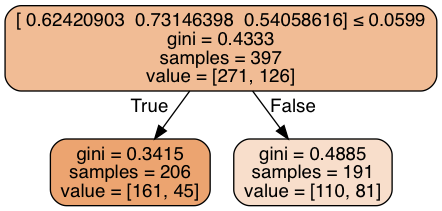

In [31]:
# Tree 1

# initialize the output file object
dot_data = StringIO() 

# my fit DecisionTreeRegressor object here is: dtree1
# for feature_names i put the columns of my Xr matrix
export_graphviz(dtree1c, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=Xcs)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

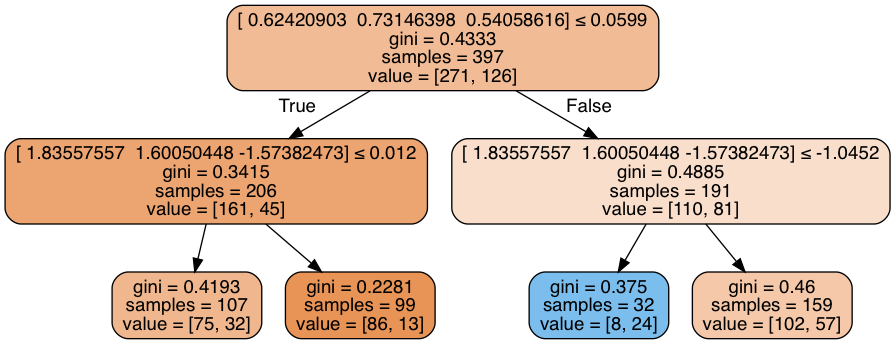

In [32]:
# Tree 2

# initialize the output file object
dot_data = StringIO() 

# my fit DecisionTreeRegressor object here is: dtree1
# for feature_names i put the columns of my Xr matrix
export_graphviz(dtree2c, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=Xcs)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

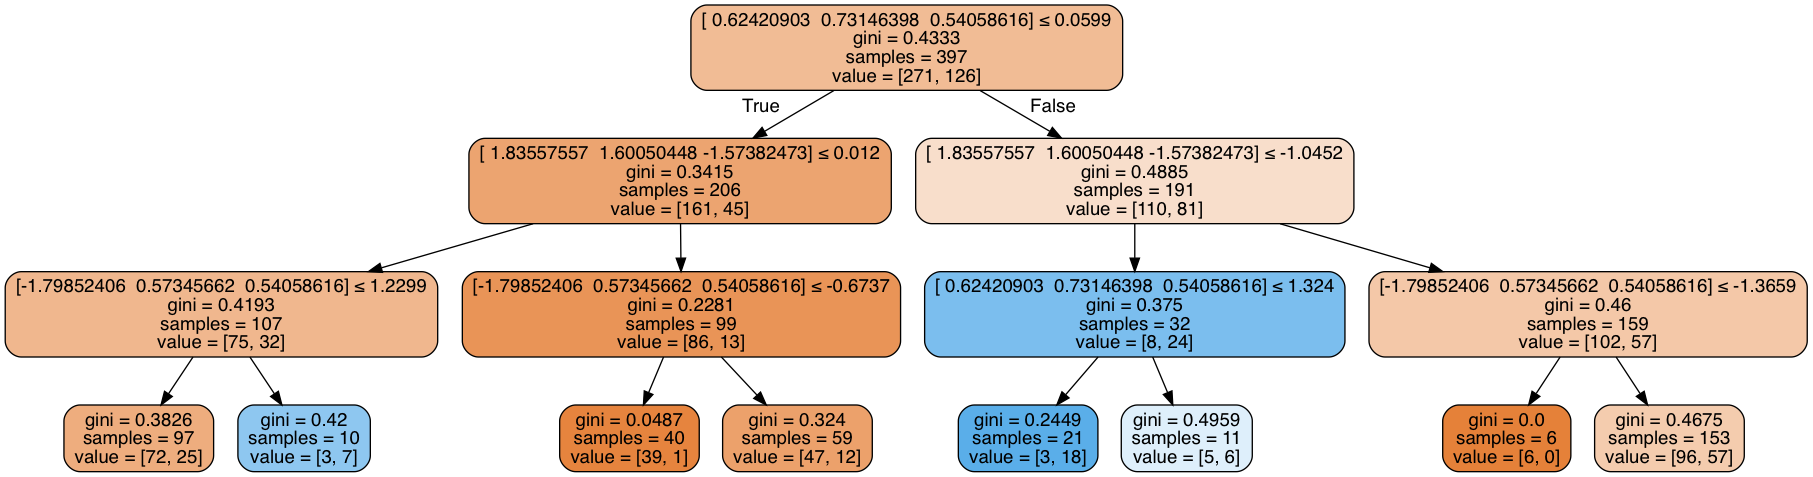

In [33]:
# Tree 3

# initialize the output file object
dot_data = StringIO() 

# my fit DecisionTreeRegressor object here is: dtree1
# for feature_names i put the columns of my Xr matrix
export_graphviz(dtree3c, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=Xcs)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

In [34]:
# Tree N

# initialize the output file object
dot_data = StringIO() 

# my fit DecisionTreeRegressor object here is: dtree1
# for feature_names i put the columns of my Xr matrix
export_graphviz(dtreeNc, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=Xcs)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


---

### 9. Using GridSearchCV to find the best decision tree classifier

As decision trees that are unrestricted will just end up over fitting the training data. Decision tree regression and classification models in sklearn offer a variety of ways to "pre-prune" (by restricting the how many times the tree can branch and what it can use).

Measure           | What it does
------------------|-------------
max_depth         | How many nodes deep can the decision tree go?
max_features      | Is there a cut off to the number of features to use?
max_leaf_nodes    | How many leaves can be generated per node?
min_samples_leaf  | How many samples need to be included at a leaf, at a minimum?  
min_samples_split | How many samples need to be included at a node, at a minimum?

It is not always best to search over _all_ of these in a grid search, unless you have a small dataset. Many of them while not redundant are going to have very similar effects on your model's fit.

Check out the documentation here:

http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

---

#### Switch over to the college stats dataset

We are going to be predicting whether or not a college is public or private. Set up your X, y variables accordingly.

In [35]:
col = pd.read_csv('./datasets/College.csv')

In [36]:
col.head()

,Unnamed: 0,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [37]:
col.shape
# 777 columns, 19 rows

(777, 19)

In [38]:
col.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 19 columns):
Unnamed: 0     777 non-null object
Private        777 non-null object
Apps           777 non-null int64
Accept         777 non-null int64
Enroll         777 non-null int64
Top10perc      777 non-null int64
Top25perc      777 non-null int64
F.Undergrad    777 non-null int64
P.Undergrad    777 non-null int64
Outstate       777 non-null int64
Room.Board     777 non-null int64
Books          777 non-null int64
Personal       777 non-null int64
PhD            777 non-null int64
Terminal       777 non-null int64
S.F.Ratio      777 non-null float64
perc.alumni    777 non-null int64
Expend         777 non-null int64
Grad.Rate      777 non-null int64
dtypes: float64(1), int64(16), object(2)
memory usage: 115.4+ KB


In [79]:
# Set X, y variables
y = col.Private.map(lambda x: 1 if x == 'Yes' else 0)
X = col.iloc[:, 2:]

In [80]:
print('X', X.shape)
print('y', y.shape)

X (777, 17)
y (777,)


In [81]:
# scale the data before modeling
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs = ss.fit_transform(X)

---

### 10. Set up and run the gridsearch on the data

In [82]:
from sklearn.model_selection import GridSearchCV

In [83]:
# gridsearch params
dtc_params = {
    'max_depth':[None,1,2,3,4],
    'max_features':[None,'log2','sqrt',2,3,4,5],
    'min_samples_split':[2,3,4,5,10,15,20,25,30,40,50]
}

from sklearn.model_selection import GridSearchCV
# set the gridsearch
dtc_gs = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=5, verbose=1)

In [84]:
# Fit the GridSearch
dtc_gs.fit(X, y)

Fitting 5 folds for each of 385 candidates, totalling 1925 fits


[Parallel(n_jobs=1)]: Done 1925 out of 1925 | elapsed:    6.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [None, 1, 2, 3, 4], 'max_features': [None, 'log2', 'sqrt', 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [85]:
dtc_best = dtc_gs.best_estimator_
print('Best parameters: ', dtc_gs.best_params_)
print('Best score: ', dtc_gs.best_score_)

Best parameters:  {'max_depth': 4, 'max_features': 5, 'min_samples_split': 20}
Best score:  0.918918918919


---

### 11. Print out the "feature importances"

The model has an attribute called `.feature_importances_` which can tell us which features were most important vs. others. It ranges from 0 to 1, with 1 being the most important.

An easy way to think about the feature importance is how much that particular variable was used to make decisions. Really though, it also takes into account how much that feature contributed to splitting up the class or reducing the variance.

A feature with higher feature importance reduced the criterion (impurity) more than the other features.

Below, show the feature importances for each variable predicting private vs. not, sorted by most important feature to least.

In [88]:
fi = pd.DataFrame({
        'feature':X.columns,
        'importance':dtc_best.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)
fi

,feature,importance
6,P.Undergrad,0.375211
5,F.Undergrad,0.185790
8,Room.Board,0.120935
15,Expend,0.117306
2,Enroll,0.096384
7,Outstate,0.036089
3,Top10perc,0.023821
13,S.F.Ratio,0.020454
4,Top25perc,0.015462
12,Terminal,0.008547
